# Data-informed polygon niche demo

This notebook inspects the horizontal and vertical permeability logs,
derives simple exponential profiles to update the tunnel prior,
and shows how to map a sampled realization from the circular model
to the segmented niche via a thin-plate RBF morphing.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.optimize import curve_fit
from scipy.interpolate import griddata


In [3]:

import tunnel_random_field as trf
from niche_geometry import (
    load_niche_segments,
    segments_to_unique_points,
    CircleToPolygonMorpher,
    plot_segments,
)

plt.rcParams["figure.figsize"] = (6.0, 4.0)
plt.rcParams["axes.grid"] = False


In [5]:

# Measurement depths [m] and permeabilities [m^2]
h_depths = np.array([0.17, 0.31, 0.45, 0.59, 0.73, 0.87, 1.01, 1.15, 1.29, 1.7, 2.5])
h_perm = np.array([
    5e-16, 2e-16, 2e-16, 2e-14, 5e-16,
    8e-13, 3e-15, 8e-16, 4e-17, 2e-20, 5e-21,
])

v_depths = np.array([0.25, 0.35, 0.45, 0.55, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.7, 3.3])
v_perm = np.array([
    2e-17, 8e-17, 8e-17, 8e-15, 7e-15, 4e-18,
    6e-18, 2e-15, 7e-16, 9e-17, 5e-17, 8e-21,
])

measurement_profiles = {
    "horizontal": {"depths": h_depths, "perm": h_perm},
    "vertical": {"depths": v_depths, "perm": v_perm},
}


In [6]:
orig_points_vertical = np.array(
    [
        [-0.00590468, -1.28667847],
        [-0.00589718, -1.43667847],
        [-0.00589218, -1.53667847],
        [-0.00588718, -1.63667847],
        [-0.00588218, -1.73667847],
        [-0.00587718, -1.83667847],
        [-0.00587218, -1.93667847],
        [-0.00586718, -2.03667847],
        [-0.00586218, -2.13667847],
        [-0.00585718, -2.23667847],
        [-0.00585218, -2.33667847],
        [-0.00584718, -2.43667847],
        [-0.00584218, -2.53667847],
        [-0.00582368, -2.87667847],
        [-0.00578568, -3.65667847],
        [-0.00574768, -4.43667847],
        [-0.00554868, -6.63667847],
        [-0.00554868, -6.63667847],
    ]
)

orig_points_horizontal = np.array(
    [
        [1.27414102, -0.16903214],
        [1.4231649, -0.15245487],
        [1.52251415, -0.14140337],
        [1.6218634, -0.13035186],
        [1.72121265, -0.11930035],
        [1.8205619, -0.10824884],
        [1.91991115, -0.09719733],
        [2.0192604, -0.08614582],
        [2.11860965, -0.07509431],
        [2.2179589, -0.0640428],
        [2.31730815, -0.05299129],
        [2.4166574, -0.04193978],
        [2.51600665, -0.03088827],
        [2.96220271, 0.01841753],
        [3.75690169, 0.10680927],
        [4.55160067, 0.19520102],
        [6.73710863, 0.4383037],
        [5.29653465, 0.27805686],
    ]
)

p_vert = np.array([-0.00591218, -1.13667847])
p_horiz = np.array([1.12506055, -0.18561569])

# Direction vectors (unit) from the niche boundary into the host rock
d_vert_unit = orig_points_vertical.mean(axis=0) - p_vert
d_vert_unit /= np.linalg.norm(d_vert_unit)

d_horiz_unit = orig_points_horizontal.mean(axis=0) - p_horiz
d_horiz_unit /= np.linalg.norm(d_horiz_unit)

h_coords = p_horiz + np.outer(h_depths, d_horiz_unit)
v_coords = p_vert + np.outer(v_depths, d_vert_unit)



In [7]:

def analyze_profile(depths, permeability, background_depth=1.5):
    depths = np.asarray(depths, dtype=float)
    perm = np.asarray(permeability, dtype=float)
    log_perm = np.log(perm)

    far_mask = depths >= background_depth
    if not np.any(far_mask):
        raise ValueError("Need at least one measurement beyond background_depth")
    mu = float(np.median(log_perm[far_mask]))

    def model(d, A, lam):
        return mu + A * np.exp(-lam * d)

    guess_A = float(np.max(log_perm) - mu)
    popt, _ = curve_fit(
        model,
        depths,
        log_perm,
        p0=(guess_A, 0.5),
        bounds=([0.1, 0.05], [30.0, 3.0]),
    )
    A_hat, lambda_hat = map(float, popt)

    near_mask = depths <= 0.8
    if np.any(near_mask):
        near_mean = float(np.mean(log_perm[near_mask]))
        near_std = float(np.std(log_perm[near_mask], ddof=1)) if near_mask.sum() > 1 else 0.0
    else:
        near_mean = float(np.mean(log_perm))
        near_std = float(np.std(log_perm, ddof=1))

    return {
        "mu": mu,
        "A": A_hat,
        "lambda": lambda_hat,
        "near_mean": near_mean,
        "near_std": near_std,
        "background_depth": background_depth,
    }

def plot_profile(ax, depths, permeability, params, label):
    log_perm = np.log(permeability)
    ax.scatter(depths, log_perm, label=f"{label} data", s=35)
    depth_plot = np.linspace(0.0, depths.max() + 0.5, 200)
    fit = params["mu"] + params["A"] * np.exp(-params["lambda"] * depth_plot)
    ax.plot(depth_plot, fit, label=f"{label} fit", linewidth=2)


In [8]:

profile_params = {}
print("profile    mu_ln(k)    mu_k [m^2]       A     lambda [1/m]")
print("-" * 60)
for name, data in measurement_profiles.items():
    params = analyze_profile(data["depths"], data["perm"], background_depth=1.5)
    profile_params[name] = params
    print(
        f"{name:<10} {params['mu']:8.3f}  {np.exp(params['mu']):10.3e}"
        f"  {params['A']:7.3f}   {params['lambda']:7.3f}"
    )


profile    mu_ln(k)    mu_k [m^2]       A     lambda [1/m]
------------------------------------------------------------
horizontal  -46.052   1.000e-20   15.282     0.498
vertical    -41.905   6.325e-19    7.569     0.482


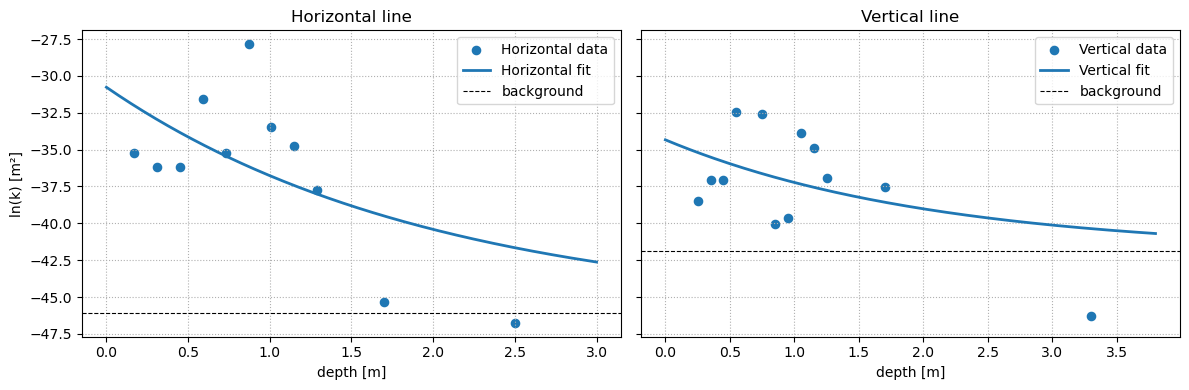

In [9]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, (name, data) in zip(axes, measurement_profiles.items()):
    params = profile_params[name]
    plot_profile(ax, data["depths"], data["perm"], params, label=name.capitalize())
    ax.axhline(params["mu"], color="k", linestyle="--", linewidth=0.8, label="background")
    ax.set_title(f"{name.capitalize()} line")
    ax.set_xlabel("depth [m]")
    ax.legend(loc="upper right")
    ax.grid(True, linestyle=":")
axes[0].set_ylabel("ln(k) [m²]")
plt.tight_layout()


### Prior setup rationale

* Deep measurements (≥1.5 m) cluster around ln(k) ≈ −44, i.e. ~7×10⁻²⁰ m², so that value is
  used as the background log-permeability.
* The two lines show 7–15 natural-log units of enhancement near the wall; we keep a mean
  amplitude of ~11 with a generous 5-unit standard deviation to cover both trends.
* Both profiles recover exponentially with λ ≈ 0.49 1/m, and we allow ±30% log-variability
  to account for local heterogeneity.
* With only two rays, circumferential structure is poorly constrained, so we assume moderate
  correlation lengths of 0.7 rad for the amplitude field and 1.2 rad for the decay-rate field.


In [10]:
mu_background = np.mean([params["mu"] for params in profile_params.values()])
A_values = [params["A"] for params in profile_params.values()]
lambda_values = [params["lambda"] for params in profile_params.values()]
sigma_A = max(4.5, float(np.std(A_values, ddof=1)))
sigma_log_lambda = max(0.25, float(np.std(np.log(lambda_values), ddof=1)))

prior_params = {
    "ell_A": 0.7,
    "sigma_A_field": 1.0,
    "mu_A": float(np.mean(A_values)),
    "sigma_A": sigma_A,
    "ell_lambda": 2.2,
    "sigma_lambda_field": 1.0,
    "lambda0": float(np.mean(lambda_values)),
    "sigma_log_lambda": sigma_log_lambda,
}
print(f"Background ln(k): {mu_background:.3f} (~{np.exp(mu_background):.2e} m^2)")
print("Circle-field hyperparameters:")
for key, value in prior_params.items():
    print(f"  {key:>18}: {value}")



Background ln(k): -43.978 (~7.95e-20 m^2)
Circle-field hyperparameters:
               ell_A: 0.7
       sigma_A_field: 1.0
                mu_A: 11.425746540598439
             sigma_A: 5.4542235024755765
          ell_lambda: 2.2
  sigma_lambda_field: 1.0
             lambda0: 0.4898826280576263
    sigma_log_lambda: 0.25


/tmp/ipykernel_905614/2791627804.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


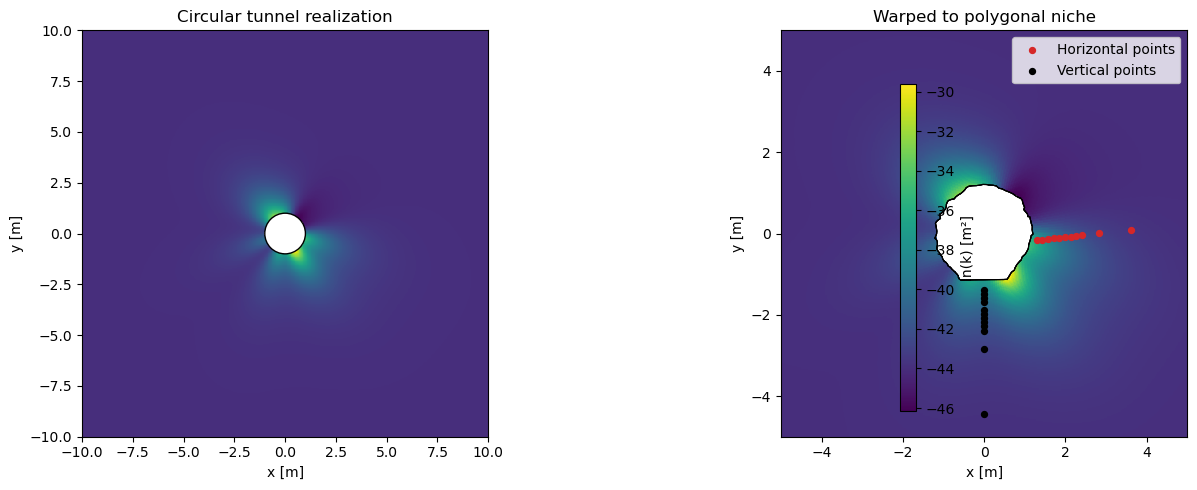

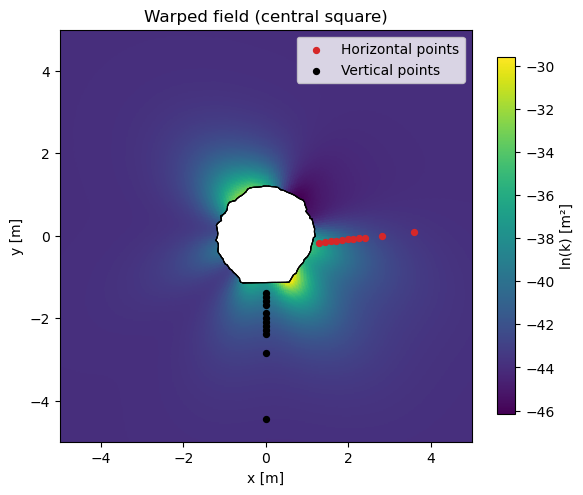

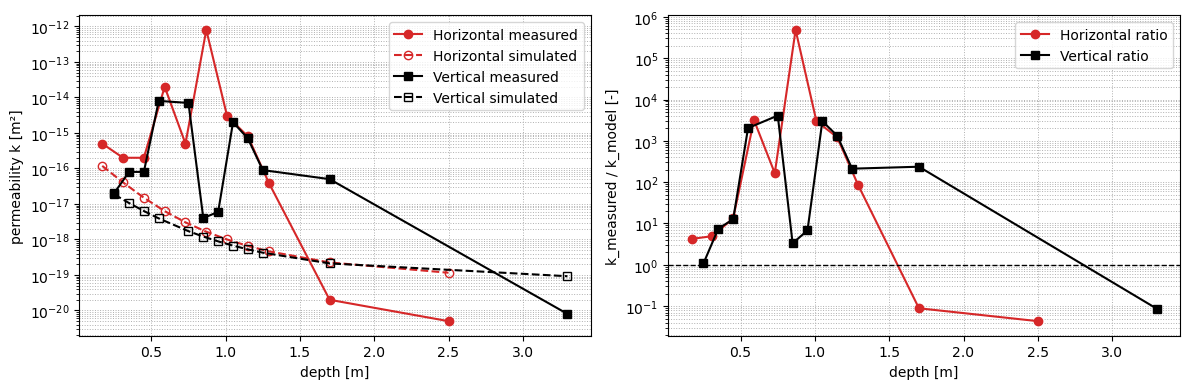

In [11]:
rng = np.random.default_rng(2025)
niche_segments = load_niche_segments("cd-a_niche4.vtu")
boundary_points = segments_to_unique_points(niche_segments)
morpher = CircleToPolygonMorpher(
    boundary_points,
    circle_radius=1.0,
    n_boundary_ctrl=200,
    n_outer_ctrl=48,
    regularization=5e-6,
)

ell_A_sample = 0.7
ell_lambda_sample = 2.2

theta, A_theta, lambda_theta = trf.sample_tunnel_circle_fields(
    n_theta=1024,
    n_modes_A=8,
    n_modes_lambda=8,
    ell_A=ell_A_sample,
    sigma_A_field=prior_params["sigma_A_field"],
    mu_A=prior_params["mu_A"],
    sigma_A=prior_params["sigma_A"],
    ell_lambda=ell_lambda_sample,
    sigma_lambda_field=prior_params["sigma_lambda_field"],
    lambda0=prior_params["lambda0"],
    sigma_log_lambda=prior_params["sigma_log_lambda"],
    force_negative=False,
    rng=rng,
)

log_k, x, y = trf.build_tunnel_logk_field(
    theta_circle=theta,
    A_theta=A_theta,
    lambda_theta=lambda_theta,
    xlim=(-10.0, 10.0),
    ylim=(-10.0, 10.0),
    nx=512,
    ny=512,
    R_tunnel=1.0,
    mu_logk=mu_background,
    mask_inside=True,
)

Xc, Yc = np.meshgrid(x, y, indexing="xy")
Xw, Yw = morpher.warp_grid(x, y)
vmin, vmax = np.nanmin(log_k), np.nanmax(log_k)

crop_limit = 5.0

valid_mask = np.isfinite(log_k.ravel())
pts_warped = np.column_stack([Xw.ravel()[valid_mask], Yw.ravel()[valid_mask]])
logk_values = log_k.ravel()[valid_mask]

color_horizontal = "tab:red"
color_vertical = "k"


def sample_logk_at(points):
    pts = np.atleast_2d(points)
    interp = griddata(pts_warped, logk_values, pts, method="linear")
    missing = np.isnan(interp)
    if np.any(missing):
        interp[missing] = griddata(pts_warped, logk_values, pts[missing], method="nearest")
    return np.squeeze(interp)


logk_h = sample_logk_at(h_coords)
logk_v = sample_logk_at(v_coords)
model_h_perm = np.exp(logk_h)
model_v_perm = np.exp(logk_v)
ratio_h = h_perm / model_h_perm
ratio_v = v_perm / model_v_perm

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
pcm0 = axes[0].pcolormesh(Xc, Yc, log_k, shading="auto", vmin=vmin, vmax=vmax)
axes[0].add_patch(Circle((0.0, 0.0), 1.0, fill=False, linewidth=1.0, color="k"))
axes[0].set_title("Circular tunnel realization")
axes[0].set_xlabel("x [m]")
axes[0].set_ylabel("y [m]")
axes[0].set_aspect("equal", "box")
axes[0].set_xlim(-10.0, 10.0)
axes[0].set_ylim(-10.0, 10.0)

pcm1 = axes[1].pcolormesh(Xw, Yw, log_k, shading="auto", vmin=vmin, vmax=vmax)
plot_segments(axes[1], niche_segments, color="k", linewidth=0.8)
axes[1].scatter(
    h_coords[:, 0],
    h_coords[:, 1],
    s=18,
    color=color_horizontal,
    marker="o",
    label="Horizontal points",
    zorder=3,
)
axes[1].scatter(
    v_coords[:, 0],
    v_coords[:, 1],
    s=18,
    color=color_vertical,
    marker="o",
    label="Vertical points",
    zorder=3,
)
axes[1].set_title("Warped to polygonal niche")
axes[1].set_xlabel("x [m]")
axes[1].set_ylabel("y [m]")
axes[1].set_aspect("equal", "box")
axes[1].set_xlim(-crop_limit, crop_limit)
axes[1].set_ylim(-crop_limit, crop_limit)
axes[1].legend(loc="upper right")

cbar = fig.colorbar(pcm1, ax=axes.ravel().tolist(), shrink=0.85)
cbar.set_label("ln(k) [m²]")
plt.tight_layout()

fig2, ax = plt.subplots(figsize=(6, 5))
pcm2 = ax.pcolormesh(Xw, Yw, log_k, shading="auto", vmin=vmin, vmax=vmax)
plot_segments(ax, niche_segments, color="k", linewidth=0.8)
ax.scatter(
    h_coords[:, 0],
    h_coords[:, 1],
    s=18,
    color=color_horizontal,
    marker="o",
    label="Horizontal points",
    zorder=3,
)
ax.scatter(
    v_coords[:, 0],
    v_coords[:, 1],
    s=18,
    color=color_vertical,
    marker="o",
    label="Vertical points",
    zorder=3,
)
ax.set_title("Warped field (central square)")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect("equal", "box")
ax.set_xlim(-crop_limit, crop_limit)
ax.set_ylim(-crop_limit, crop_limit)
ax.legend(loc="upper right")

cbar2 = fig2.colorbar(pcm2, ax=ax, shrink=0.85)
cbar2.set_label("ln(k) [m²]")
plt.tight_layout()

fig3, (ax_perm, ax_ratio) = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
ax_perm.semilogy(
    h_depths,
    h_perm,
    color=color_horizontal,
    marker="o",
    linestyle="-",
    label="Horizontal measured",
)
ax_perm.semilogy(
    h_depths,
    model_h_perm,
    color=color_horizontal,
    marker="o",
    linestyle="--",
    mfc="none",
    label="Horizontal simulated",
)
ax_perm.semilogy(
    v_depths,
    v_perm,
    color=color_vertical,
    marker="s",
    linestyle="-",
    label="Vertical measured",
)
ax_perm.semilogy(
    v_depths,
    model_v_perm,
    color=color_vertical,
    marker="s",
    linestyle="--",
    mfc="none",
    label="Vertical simulated",
)
ax_perm.set_xlabel("depth [m]")
ax_perm.set_ylabel("permeability k [m²]")
ax_perm.grid(True, which="both", linestyle=":", linewidth=0.7)
ax_perm.legend()

ax_ratio.semilogy(
    h_depths,
    ratio_h,
    color=color_horizontal,
    marker="o",
    linestyle="-",
    label="Horizontal ratio",
)
ax_ratio.semilogy(
    v_depths,
    ratio_v,
    color=color_vertical,
    marker="s",
    linestyle="-",
    label="Vertical ratio",
)
ax_ratio.axhline(1.0, color="k", linewidth=1.0, linestyle="--")
ax_ratio.set_xlabel("depth [m]")
ax_ratio.set_ylabel("k_measured / k_model [-]")
ax_ratio.grid(True, which="both", linestyle=":", linewidth=0.7)
ax_ratio.legend()
plt.tight_layout()

